# Latency
This notebook analyzes the latency workload.

In [892]:
# settings for saving plots
saveplots = True
dpiResolution = 100
framework = "KAFKASTREAMS"

In [893]:
from pyspark.sql.functions import *
import numpy as np
# Import to indent the plots in the notebook
%matplotlib notebook
%matplotlib inline
import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.collections as collections
import seaborn as sns
from IPython.core.display import display, HTML
from PIL import Image
from matplotlib.offsetbox import (TextArea, DrawingArea, OffsetImage,
                                  AnnotationBbox)
warnings.simplefilter('ignore', Image.DecompressionBombWarning)
import matplotlib.gridspec as gridspec

from matplotlib.lines import Line2D

In [894]:
# Python imports
import pandas as pd 
from collections import defaultdict
from datetime import timedelta
from datetime import datetime
import numpy as np
import pytz
import math

# SQL imports
from pyspark.sql.functions import isnan, when, count, col, lead, udf, lag, to_date, avg, desc, sum
from pyspark.sql import Window
from pyspark.sql import functions
from pyspark.sql.types import IntegerType, LongType, DoubleType, TimestampType, StringType

In [895]:
plt.style.use('ggplot')
plt.style.use('seaborn-deep')
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 22
plt.rcParams['axes.labelsize'] = 22
plt.rcParams['axes.labelweight'] = 'normal'
plt.rcParams['axes.labelcolor'] = 'black'
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['axes.edgecolor'] = 'lightgrey'
plt.rcParams['axes.titlesize'] = 22
plt.rcParams['axes.titleweight'] = 'normal'
plt.rcParams['figure.edgecolor'] = 'lightgrey'
plt.rcParams['xtick.labelsize'] = 22
plt.rcParams['ytick.labelsize'] = 22
plt.rcParams['legend.fontsize'] = 22
plt.rcParams['figure.titlesize'] = 22
plt.rcParams['figure.titleweight'] ='bold'
plt.rcParams['grid.color'] = 'grey'
plt.rcParams['grid.linestyle'] = ':'
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.left'] = False
plt.rcParams['axes.spines.bottom'] = False
plt.rcParams['xtick.direction'] = 'out'
plt.rcParams['ytick.direction'] ='out'
plt.rcParams['xtick.color'] = 'black'
plt.rcParams['ytick.color'] = 'black'
plt.rcParams["date.autoformatter.minute"] = "%H:%M"
plt.rcParams["font.family"] = "Times New Roman"
plt.rc('axes',edgecolor='black')

In [896]:
spark

In [897]:
frameworks_that_could_be_in_the_data = [framework]
frameworksPrinted= {
    "SPARK":"Spark Streaming",
    "STRUCTUREDSTREAMING":"Structured Streaming",
    "FLINK":"Flink",
    "KAFKASTREAMS":"Kafka Streams"
}

windowtypes = ["custom", "normal"]

stages=["ingest", "parse", "join", "tumbling \n window", "sliding \n window"]

In [898]:
dataPath = defaultdict(dict)
i = framework
for p in [0,1,2,3,4]:
    dataPath[p]["custom"] = "./data/" + i + "/latency-constant-rate/custom-windows/*"
    dataPath[p]["normal"] = "./data/" + i + "/latency-constant-rate/normal-windows/*"
    

In [899]:
dataPath

defaultdict(dict,
            {0: {'custom': './data/KAFKASTREAMS/latency-constant-rate/custom-windows/*',
              'normal': './data/KAFKASTREAMS/latency-constant-rate/normal-windows/*'},
             1: {'custom': './data/KAFKASTREAMS/latency-constant-rate/custom-windows/*',
              'normal': './data/KAFKASTREAMS/latency-constant-rate/normal-windows/*'},
             2: {'custom': './data/KAFKASTREAMS/latency-constant-rate/custom-windows/*',
              'normal': './data/KAFKASTREAMS/latency-constant-rate/normal-windows/*'},
             3: {'custom': './data/KAFKASTREAMS/latency-constant-rate/custom-windows/*',
              'normal': './data/KAFKASTREAMS/latency-constant-rate/normal-windows/*'},
             4: {'custom': './data/KAFKASTREAMS/latency-constant-rate/custom-windows/*',
              'normal': './data/KAFKASTREAMS/latency-constant-rate/normal-windows/*'}})

## General Methods

For printing the quantiles of a column:
provide a list of quantiles

In [900]:
def printApproxQuantiles(df, colName, quantiles):
    quantileList = df.approxQuantile(colName, quantiles, 0)
    print("Quantiles for feature %s:" % (colName))
    for i in range(len(quantiles)):
        print("Quantile %.3f: %.1f" % (quantiles[i], quantileList[i]))

In [901]:
def datetimeFromEpoch(epoch):
    return datetime.utcfromtimestamp(epoch//1000).replace(microsecond=epoch%1000*1000)

datetimeFromEpochUDF = functions.udf(datetimeFromEpoch, TimestampType())

In [902]:
def phase_to_stage(i):
    stages=["ingest", "parse", "join", "tumbling\nwindow", "sliding\nwindow"]
    return stages[i]

In [903]:
def set_annotations(y_pos=1, annotate_frameworks=True):
    pad = 5
    if annotate_frameworks:
        for axis, framework in zip(ax[0], frameworks):
            axis.annotate(framework, xy=(0.5, y_pos), xytext=(0, pad),
                    xycoords='axes fraction', textcoords='offset points',
                    size='medium', ha='center', va='baseline')

    for axis, stage in zip(ax[:,0], stages):
        axis.annotate(stage, xy=(0, 0.5), xytext=(-axis.yaxis.labelpad - pad, 0),
                    xycoords=axis.yaxis.label, textcoords='offset points',
                    size='medium', ha='right', va='center', rotation='vertical')

In [904]:
def save_img_colored_and_grayscale(path_colored_img):
    if saveplots: 
        plt.savefig(path_colored_img + '.png', dpi=dpiResolution, bbox_inches="tight", pad_inches=0.08)
        im = Image.open(path_colored_img + '.png').convert('L')
        im.save(path_colored_img + '_grayscale.png', dpi=(300, 300))

In [905]:
def to_float(a):
    try:
        return float(a)
    except:
        return float(a.replace(",", ""))

# Latency 
Read in latency data and transform in the right format for plotting.

In [906]:
dataPath

defaultdict(dict,
            {0: {'custom': './data/KAFKASTREAMS/latency-constant-rate/custom-windows/*',
              'normal': './data/KAFKASTREAMS/latency-constant-rate/normal-windows/*'},
             1: {'custom': './data/KAFKASTREAMS/latency-constant-rate/custom-windows/*',
              'normal': './data/KAFKASTREAMS/latency-constant-rate/normal-windows/*'},
             2: {'custom': './data/KAFKASTREAMS/latency-constant-rate/custom-windows/*',
              'normal': './data/KAFKASTREAMS/latency-constant-rate/normal-windows/*'},
             3: {'custom': './data/KAFKASTREAMS/latency-constant-rate/custom-windows/*',
              'normal': './data/KAFKASTREAMS/latency-constant-rate/normal-windows/*'},
             4: {'custom': './data/KAFKASTREAMS/latency-constant-rate/custom-windows/*',
              'normal': './data/KAFKASTREAMS/latency-constant-rate/normal-windows/*'}})

In [907]:
# Save the data in here
completeResults = dict()

# Save the frameworks present in the data in here
frameworks = [framework]
phases = {"custom": [], "normal": []}

for windowtype in windowtypes:
    try:
        completeResults[windowtype] = spark.read.option("header", "true").option("inferSchema", "true") \
            .csv(dataPath[phase][windowtype] + "/results.csv/*")
        phases[windowtype] = list(completeResults[windowtype].select(col("phase")).distinct().orderBy(col("phase")).toPandas()["phase"])
    except:
        print("no data for " + str(windowtype))

In [908]:
phases

{'custom': [3, 4], 'normal': [0, 1, 2, 3, 4]}

In [909]:
# # Save the frameworks present in the data in here
# containerCheck = defaultdict(dict)

# for phase in unique_phases:
#     for windowtype in windowtypes:
#         try:
#             print(str(phase) + str(windowtype))
#             if framework == "KAFKASTREAMS":
#                 requiredAmtContainers = 5 
#             elif framework == "FLINK": 
#                 requiredAmtContainers = 6
#             else:
#                 requiredAmtContainers = 6
#             containerCheckPhase = spark.read.option("header", "true").option("inferSchema", "true") \
#             .csv(dataPath[phase][windowtype] + "/cpu-per-container-timeseries.csv/*").filter(col("phase")==phase)
#             amtOfContainers = containerCheckPhase.select("containerName").distinct().count()
#             phases[windowtype].append(phase)
                
#         except:
#             print("no data for: " + str(phase) + " - " + windowtype)

In [910]:
print(phases)

{'custom': [3, 4], 'normal': [0, 1, 2, 3, 4]}


In [911]:
print("Unique phases in the data: " + str(unique_phases))
print("Frameworks in the data: " + str(frameworks))
print("Phases per framework: ")
display(phases)

Unique phases in the data: [0, 1, 2, 3, 4]
Frameworks in the data: ['KAFKASTREAMS']
Phases per framework: 


{'custom': [3, 4], 'normal': [0, 1, 2, 3, 4]}

In [912]:
for windowtype in windowtypes:
    for phase in phases[windowtype]:
        try:
            display(completeResults[windowtype].filter(col("phase")==phase).toPandas())
        except:
            print("doesn't exist: phase" + str(phase) + " windowtype: "+ windowtype)

,framework,phase,scale,bufferTimeout,shortLb,longLb,startTime,latencyType,avgLatency,stddevLatency,...,max_rx,p1_rx,p5_rx,p25_rx,p50_rx,p75_rx,p95_rx,p99_rx,p999_rx,p99999_rx
0,kafka,3,0,100,1,2,1575454746630,single,209.062,55.941,...,2302.0,828.01,888.05,1188.25,1569.0,1942.75,2232.95,2288.99,2301.0,2301.98799


,framework,phase,scale,bufferTimeout,shortLb,longLb,startTime,latencyType,avgLatency,stddevLatency,...,max_rx,p1_rx,p5_rx,p25_rx,p50_rx,p75_rx,p95_rx,p99_rx,p999_rx,p99999_rx
0,kafka,4,0,100,1,2,1575457444854,single,268.719,66.741,...,4253.0,2426.0,2498.0,2871.0,3329.0,3789.0,4163.0,4237.0,4251.8,4252.988


,framework,phase,scale,bufferTimeout,shortLb,longLb,startTime,latencyType,avgLatency,stddevLatency,...,max_rx,p1_rx,p5_rx,p25_rx,p50_rx,p75_rx,p95_rx,p99_rx,p999_rx,p99999_rx
0,kafka,0,0,0,1,2,1560734749014,single,0.366,0.623,...,None,None,None,None,None,None,None,None,None,None


,framework,phase,scale,bufferTimeout,shortLb,longLb,startTime,latencyType,avgLatency,stddevLatency,...,max_rx,p1_rx,p5_rx,p25_rx,p50_rx,p75_rx,p95_rx,p99_rx,p999_rx,p99999_rx
0,kafka,1,0,0,1,2,1560737421541,single,0.851,0.663,...,None,None,None,None,None,None,None,None,None,None


,framework,phase,scale,bufferTimeout,shortLb,longLb,startTime,latencyType,avgLatency,stddevLatency,...,max_rx,p1_rx,p5_rx,p25_rx,p50_rx,p75_rx,p95_rx,p99_rx,p999_rx,p99999_rx
0,kafka,2,0,0,1,2,1560740119057,single,2.898,4.201,...,None,None,None,None,None,None,None,None,None,None


,framework,phase,scale,bufferTimeout,shortLb,longLb,startTime,latencyType,avgLatency,stddevLatency,...,max_rx,p1_rx,p5_rx,p25_rx,p50_rx,p75_rx,p95_rx,p99_rx,p999_rx,p99999_rx
0,kafka,3,0,0,1,2,1560742816360,single,533.724,309.184,...,None,None,None,None,None,None,None,None,None,None


,framework,phase,scale,bufferTimeout,shortLb,longLb,startTime,latencyType,avgLatency,stddevLatency,...,max_rx,p1_rx,p5_rx,p25_rx,p50_rx,p75_rx,p95_rx,p99_rx,p999_rx,p99999_rx
0,kafka,4,0,0,1,2,1560745513785,single,908.934,401.831,...,None,None,None,None,None,None,None,None,None,None


Phases that are present in the data

In [913]:
latencyTimeseriesDataWithStartup = defaultdict(dict)
for windowtype in windowtypes:
    for phase in phases[windowtype]:
        try:
            latencyTimeseriesDataPhase = spark.read.option("header", "true").option("inferSchema", "true") \
                .csv(dataPath[phase][windowtype] + "/latency-timeseries-data-without-startup.csv/*") \
                .withColumn("time", datetimeFromEpochUDF(col("outputBucketTime"))).filter(col("phase")==phase)
            minTime = latencyTimeseriesDataPhase \
                .agg(min("outputBucketTime").alias("minTime")).toPandas()["minTime"][0].item()
            minTimeSec = minTime/60000.0
            latencyTimeseriesDataWithStartup[phase][windowtype] = latencyTimeseriesDataPhase.withColumn("timeSec", (col("outputBucketTime")/60000.0)-minTimeSec)
        except:
            print("no data for " +  windowtype + " for stage " + str(phase))

In [914]:
latencyHistogramData = defaultdict(dict)
for windowtype in windowtypes:
    for phase in phases[windowtype]:
        latencyHistogramData[phase][windowtype] = spark.read.option("header", "true").option("inferSchema", "true") \
            .csv(dataPath[phase][windowtype] + "/latency-violin-without-startup-data.csv/*").filter(col("phase")==phase)

In [915]:
def createLatencyPlot(windowTypeForPlot):
    for j, windowtype in enumerate(windowTypeForPlot):
        f, ax = plt.subplots(len(windowTypeForPlot), 1 , figsize=(3.8, 1+1.2*len(phases[windowtype])))
        spread = 2.5
        xax_max = 7000.0
        yax_max = 5*spread -0.5
        endvalue = math.ceil(xax_max)
        y_coors = list(reversed(range(0, len(phases[windowtype]))))
        
        for i, phase in enumerate(phases[windowtype]):
            y_coor = y_coors[i]*spread
            
            completeResultOfPhase = completeResults[windowtype].filter(col("phase")==phase).toPandas()
            p99999=completeResultOfPhase["p99999"][0]
            p999=completeResultOfPhase["p999"][0]
            latencyHistogramDataPhase = latencyHistogramData[phase][windowtype].withColumn("latencyBucket", round(col("latencyBucket") / 10.0)*10) \
                .groupBy("latencyBucket").agg(sum("latencyBucketCount").alias("latencyBucketCount")).orderBy("latencyBucket") \
                .toPandas()

            # Create horizontal lines for each of the phases
            ax.axhline(y_coor, linestyle='-', color='#E8E8E8')
            # Put the phase label 
            ax.annotate("+ " + phase_to_stage(phase), 
                           xy=(10, y_coor), 
                           xytext=(-ax.yaxis.labelpad - 5, 0),
                           textcoords='offset points', 
                           size=22, 
                           ha='right', 
                           va='baseline')

            divisorMax = latencyHistogramDataPhase["latencyBucketCount"].max()
            latencyHistogramDataPhase["latencyBucketCount"] = latencyHistogramDataPhase["latencyBucketCount"]\
                .apply(lambda x: (x/divisorMax) + y_coor)
            ymax = latencyHistogramDataPhase["latencyBucketCount"].max()
            latencyLine = ax.plot(latencyHistogramDataPhase["latencyBucket"], latencyHistogramDataPhase["latencyBucketCount"], color="#484848")
            p50=completeResultOfPhase["p50"][0]
            p50line = ax.axvline(p50, ymin=y_coor/yax_max, ymax=(y_coor+0.95)/yax_max, linestyle='--', color='black', label='p50/median')
            p50_text_box = TextArea(int(p50), minimumdescent=False, textprops=dict(size = 22))
            p50_ab = AnnotationBbox(p50_text_box, (p50, y_coor+1.1),
                            xybox=(-15, 15),
                            xycoords='data',
                            boxcoords="offset points",
                            pad=0.08,
                            arrowprops=dict(arrowstyle="->"))
            ax.add_artist(p50_ab)

            p999line = ax.axvline(p999, ymin=y_coor/yax_max, ymax=(y_coor+1.2)/yax_max, linestyle=':', color='black', label='p999')

            p999_text_box = TextArea(int(p999), minimumdescent=False, textprops=dict(size = 22))
            p999_ab = AnnotationBbox(p999_text_box, (p999, y_coor+1.1),
                            xybox=(9, 15),
                            xycoords='data',
                            boxcoords="offset points",
                            pad=0.08,
                            arrowprops=dict(arrowstyle="->"))
            ax.add_artist(p999_ab)
            

            ax.fill_between(latencyHistogramDataPhase["latencyBucket"], y_coor, latencyHistogramDataPhase["latencyBucketCount"],\
                             where = latencyHistogramDataPhase["latencyBucket"] <=completeResultOfPhase["p25"][0], \
                                 color='#ffffff', alpha=0.8)
            p2550fill=ax.fill_between(latencyHistogramDataPhase["latencyBucket"], y_coor, latencyHistogramDataPhase["latencyBucketCount"],\
                             where = (latencyHistogramDataPhase["latencyBucket"] <=completeResultOfPhase["p50"][0]) & \
                                 (latencyHistogramDataPhase["latencyBucket"] >=completeResultOfPhase["p25"][0]), \
                                 color='#E8E8E8', alpha=0.8, interpolate=True)
            p5075fill=ax.fill_between(latencyHistogramDataPhase["latencyBucket"], y_coor, latencyHistogramDataPhase["latencyBucketCount"],\
                             where = (latencyHistogramDataPhase["latencyBucket"]>=completeResultOfPhase["p50"][0]) & \
                                 (latencyHistogramDataPhase["latencyBucket"]<=completeResultOfPhase["p75"][0]),\
                                 color='#787878', alpha=0.8, interpolate=True)
            p7599fill=ax.fill_between(latencyHistogramDataPhase["latencyBucket"], y_coor, latencyHistogramDataPhase["latencyBucketCount"],\
                             where = (latencyHistogramDataPhase["latencyBucket"]>=completeResultOfPhase["p75"][0]) & \
                                 (latencyHistogramDataPhase["latencyBucket"]<=completeResultOfPhase["p99"][0]), \
                                 color='#484848', alpha=0.8, interpolate=True)
            ax.fill_between(latencyHistogramDataPhase["latencyBucket"], y_coor, latencyHistogramDataPhase["latencyBucketCount"],\
                             where = (latencyHistogramDataPhase["latencyBucket"]>=completeResultOfPhase["p99"][0]), \
                                 color='#000000', alpha=0.8, interpolate=True)
        ax.get_yaxis().set_ticks([])
        ax.set_ylim(ymin=0, ymax=len(y_coors)*spread)
        ax.set_xlim(xmin=0, xmax=xax_max*1.1)



    f.legend([p50line, p999line, p2550fill, p5075fill, p7599fill], ["p50/median", "p99.9", "p25-p50", "p50-p75", "p75-p99"], loc='upper center', bbox_to_anchor=(0.5, 1.1), 
            bbox_transform=plt.gcf().transFigure, ncol =5, fontsize='24', edgecolor='white', framealpha=0,
           handletextpad=0.2, columnspacing=1)

    ax.set_xlabel("latency (ms)") 

    plt.tight_layout(rect=[0, 0, 1, 1])
    plt.subplots_adjust(wspace=0, hspace=0)

    save_img_colored_and_grayscale("./figures/latency-constant-rate/custom-normal-window-analysis/latency_distribution_" + framework + "_" + windowtype)
    plt.show()

    # to put 99.999 label:
    #         ax[j].annotate(str(int(p99999)), xy=(endvalue, i*spread+0.3), xytext=(endvalue, i*spread+0.3), size=20, \
    #                        ha='left', va='baseline', clip_on=True)

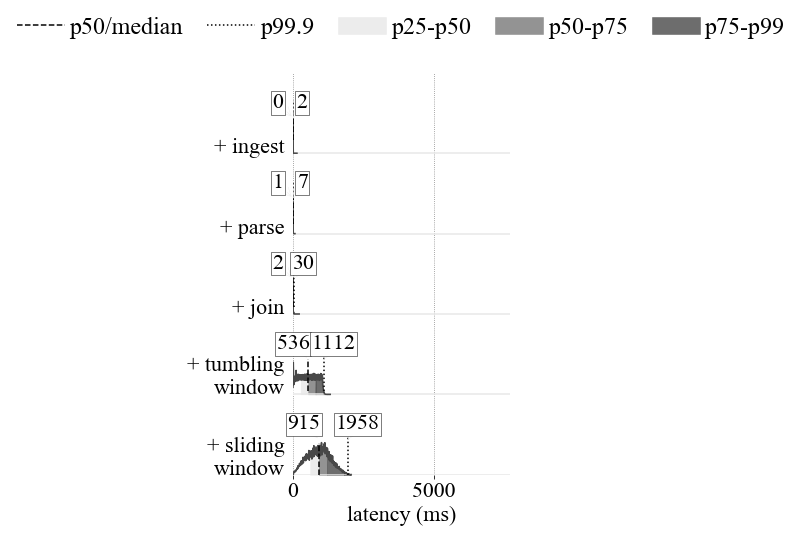

In [916]:
createLatencyPlot(["normal"])

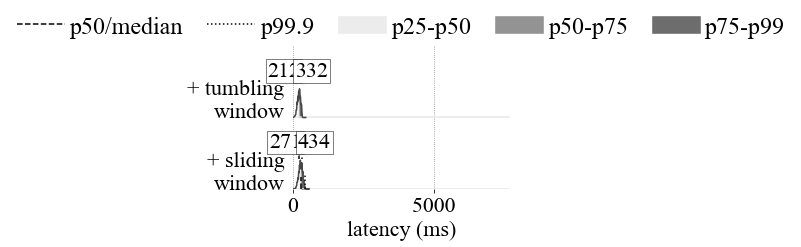

In [917]:
createLatencyPlot(["custom"])